# Download Data

In [1]:
!gdown --id 1ZJq9yRMm4ZENAjcBt-vjdXOZnzLoK0Vj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZJq9yRMm4ZENAjcBt-vjdXOZnzLoK0Vj
To: /content/Dataset.zip
100% 11.1M/11.1M [00:00<00:00, 136MB/s]


In [ ]:
!unzip "/content/Dataset.zip"

In [3]:
!rm -r /content/sample_data

# Install Model

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip install wandb

#Imports

In [6]:
import wandb
import glob
import torch, detectron2
import matplotlib.pyplot as plt
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import matplotlib
import matplotlib.pyplot
import matplotlib.patches
from detectron2.engine import DefaultTrainer
from IPython.display import YouTubeVideo, display
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from PIL import Image

In [7]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


# Load Dataset

In [8]:
def prepare_Dataloader(train_images_path,dev_images_path,train_labels_path,dev_labels_path):
  '''
  register Dataset as a coco instance
  '''
  register_coco_instances("my_datasettrain", {}, train_labels_path, train_images_path)
  register_coco_instances("my_datasetval", {}, dev_labels_path, dev_images_path)
  train_metadata = MetadataCatalog.get("my_datasettrain")

  return train_metadata

In [9]:
train_metadata = prepare_Dataloader("/content/Dataset/Train", "/content/Dataset/Dev","/content/Dataset/Train_Labels.json","/content/Dataset/Dev_Labels.json")

#Samples from the Data

In [10]:
def show_images(images):
  n = len(images)
  f = plt.figure(figsize=(10, 9))
  for i in range(n):
    f.add_subplot(1, n, i + 1)
    plt.axis('off')
    plt.imshow(images[i])
  plt.show(block=True)

In [11]:
images = [cv2.cvtColor(cv2.imread(file,), cv2.COLOR_BGR2RGB) for file in glob.glob("/content/Dataset/Train/*.png")]

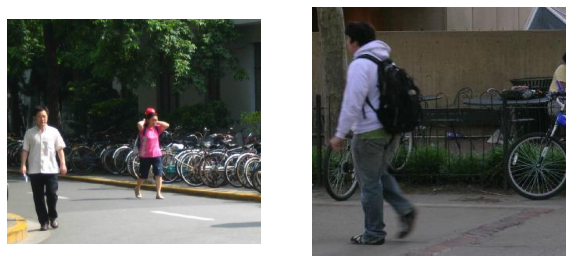

In [12]:
show_images(images[2:4]);

# Train

Here we fine-tuned a pretrained model which is **R50-FPN Mask R-CNN** on our dataset.


In [13]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
wandb.init(project="test-detectron", entity="pedestrian-segmentation")

wandb: Currently logged in as: salmagg (pedestrian-segmentation). Use `wandb login --relogin` to force relogin


In [13]:
def Train(NUM_WORKERS,IMS_PER_BATCH,BASE_LR,MAX_ITER,BATCH_SIZE_PER_IMAGE,NUM_CLASSES):
  """
  prepare configurations to train the model
  """
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.DATASETS.TRAIN = ("my_datasettrain",)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = NUM_WORKERS
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
  cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH 
  cfg.SOLVER.BASE_LR = BASE_LR 
  cfg.SOLVER.MAX_ITER = MAX_ITER  
  cfg.SOLVER.STEPS = []     
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE  
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
  trainer = DefaultTrainer(cfg) 
  trainer.resume_or_load(resume=False)

  return cfg,trainer

In [14]:
cfg,trainer = Train(2,2,0.00025, 300,128, 1)

[05/28 16:06:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:05, 34.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

In [17]:
trainer.train()

[05/28 12:55:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/28 12:55:27 d2.utils.events]:  eta: 0:01:52  iter: 19  total_loss: 2.046  loss_cls: 0.573  loss_box_reg: 0.7527  loss_mask: 0.6913  loss_rpn_cls: 0.01777  loss_rpn_loc: 0.005177  time: 0.4099  data_time: 0.0210  lr: 1.6068e-05  max_mem: 2289M
[05/28 12:55:35 d2.utils.events]:  eta: 0:01:44  iter: 39  total_loss: 2.044  loss_cls: 0.4909  loss_box_reg: 0.8536  loss_mask: 0.6728  loss_rpn_cls: 0.01556  loss_rpn_loc: 0.005076  time: 0.4059  data_time: 0.0106  lr: 3.2718e-05  max_mem: 2444M
[05/28 12:55:43 d2.utils.events]:  eta: 0:01:35  iter: 59  total_loss: 1.83  loss_cls: 0.3786  loss_box_reg: 0.7893  loss_mask: 0.639  loss_rpn_cls: 0.008241  loss_rpn_loc: 0.005882  time: 0.4037  data_time: 0.0089  lr: 4.9367e-05  max_mem: 2497M
[05/28 12:55:52 d2.utils.events]:  eta: 0:01:29  iter: 79  total_loss: 1.655  loss_cls: 0.3119  loss_box_reg: 0.7541  loss_mask: 0.5924  loss_rpn_cls: 0.01644  loss_rpn_loc: 0.004618  time: 0.4061  data_time: 0.0101  lr: 6.6017e-05  max_mem: 2497M
[05/28 12:

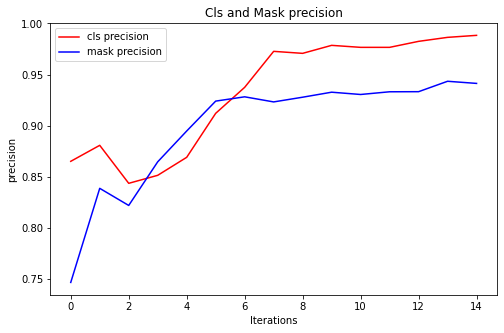

In [76]:
Image.open("/content/pre.png")

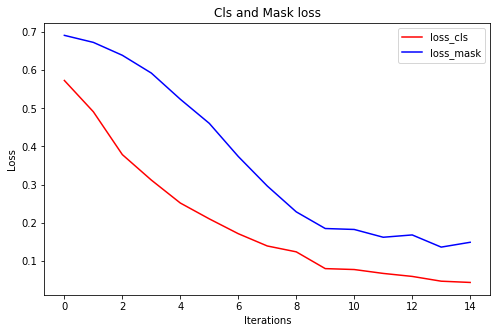

In [75]:
Image.open("/content/loss.png")

In [ ]:
wandb.save('/content/output/model_final.pth')

# Inference
Run inference with the trained model



In [15]:
best_model = wandb.restore('model_final.pth', run_path="pedestrian-segmentation/test-detectron/q5yi8t6t")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
def predictor(model_cfg, model_checkpoint):
  """
  create a predictor using your model weights
  """
  model_cfg.MODEL.WEIGHTS = model_checkpoint 
  model_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
  predictor = DefaultPredictor(model_cfg)

  return model_cfg,predictor

In [17]:
cfg,predictor = predictor(cfg,best_model.name)

[05/28 16:08:27 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [20]:
def display_pred(image_path):
  im = cv2.imread(image_path)
  outputs = predictor(im)  
  v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW 
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize=(10, 8))
  plt.axis('off')
  plt.imshow(out.get_image()[:, :, ::-1],) 
  plt.show();

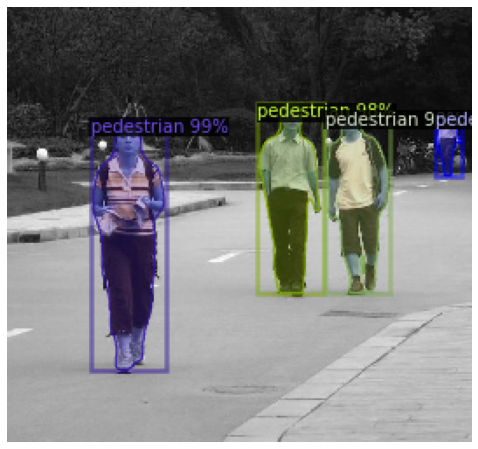

In [36]:
display_pred('/content/Dataset/Test/FudanPed00054.png')

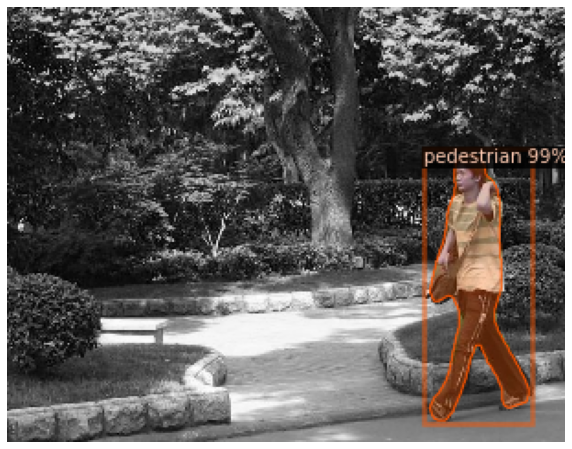

In [22]:
display_pred('/content/Dataset/Test/FudanPed00032.png')

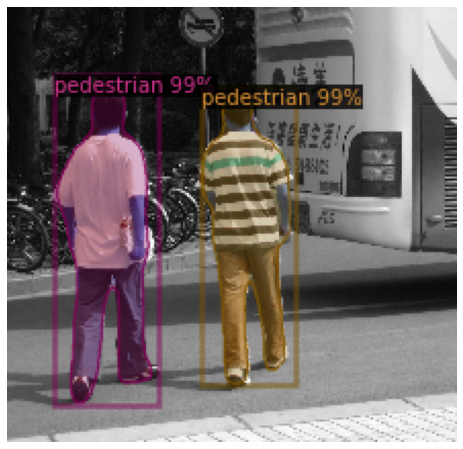

In [23]:
display_pred('/content/Dataset/Test/FudanPed00026.png')

#Segmentation

In [24]:
from PIL import Image

In [26]:
def segment_image(Image_path,predictor):
  """
  segment the background from the detected mask
  """
  Image = cv2.imread(Image_path)
  Image_gray = cv2.imread(Image_path,0)
  outputs = predictor(Image)
  pred_masks = outputs["instances"].get_fields()['pred_masks']
  pred_objects = outputs["instances"].get_fields()['pred_masks'].shape[0]

  for obj in range(pred_objects):
    for i in range(pred_masks[obj].shape[0]):
      for j in range(pred_masks[obj].shape[1]):
        if pred_masks[obj][i][j].item() == True:
          Image_gray[i][j]= 255

  for i in range(Image_gray.shape[0]):
    for j in range(Image_gray.shape[1]):
      if Image_gray[i][j] != 255:
        Image_gray[i][j] = 0
  return Image_gray

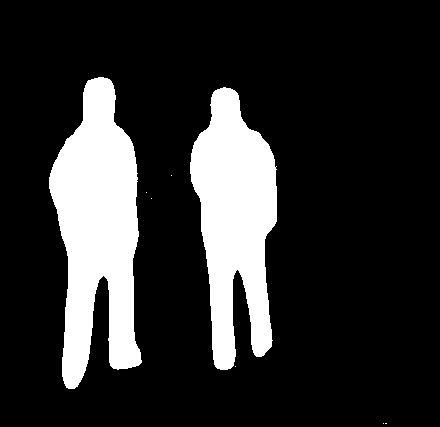

In [27]:
segmented_image = segment_image("/content/Dataset/Test/FudanPed00026.png",predictor)
Image.fromarray(segmented_image)

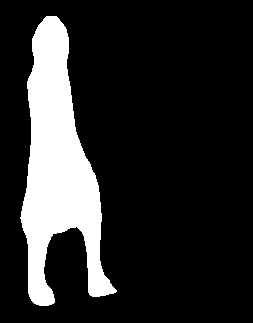

In [28]:
segmented_image = segment_image("/content/Dataset/Test/FudanPed00018.png",predictor)
Image.fromarray(segmented_image)

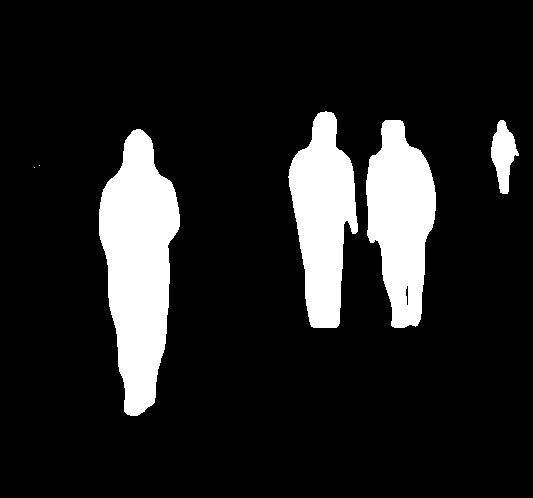

In [29]:
segmented_image = segment_image("/content/Dataset/Test/FudanPed00054.png",predictor)
Image.fromarray(segmented_image)

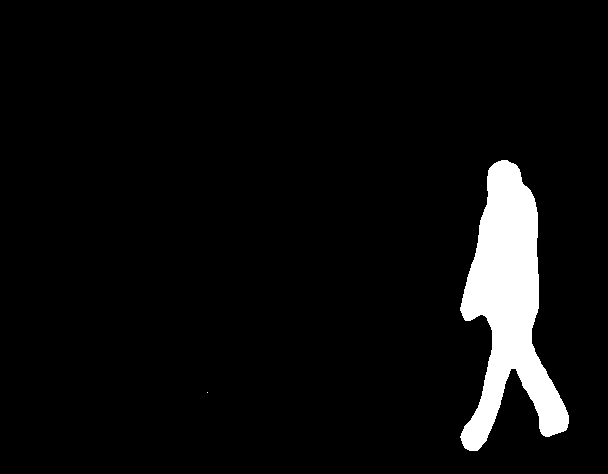

In [30]:
segmented_image = segment_image("/content/Dataset/Test/FudanPed00032.png",predictor)
Image.fromarray(segmented_image)

#Test On Images Not from our test Dataset

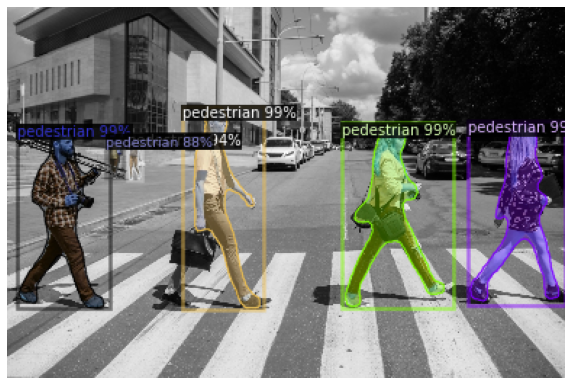

In [37]:
display_pred("/content/test1.jpg")

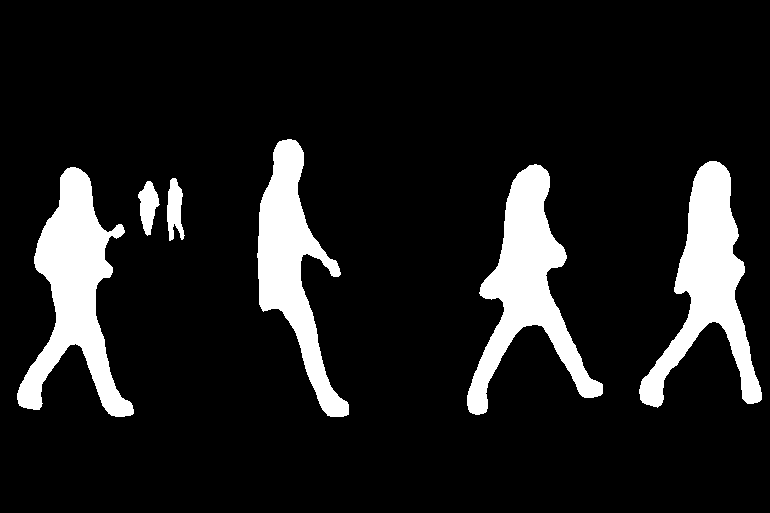

In [38]:
segmented_image = segment_image("/content/test1.jpg",predictor)
Image.fromarray(segmented_image)

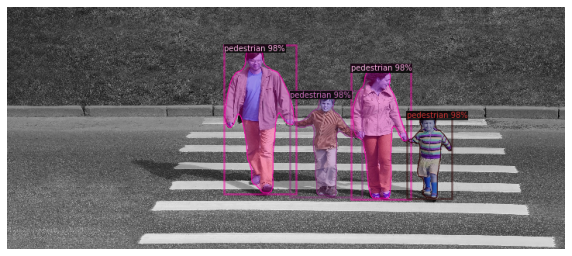

In [34]:
display_pred("/content/test2.jpg")

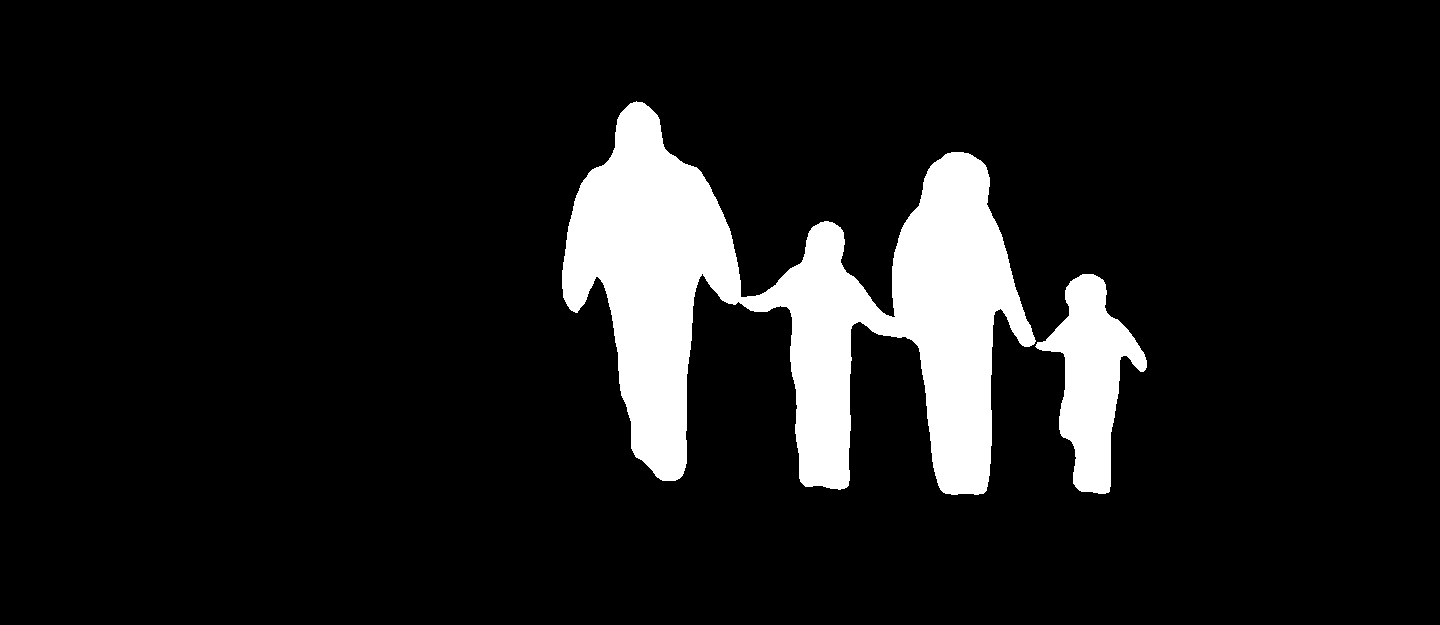

In [35]:
segmented_image = segment_image("/content/test2.jpg",predictor)
Image.fromarray(segmented_image)